In [1]:
import os
import pandas as pd
import numpy as np
import pydicom
import cv2
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0  # Using smaller variant
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate, Embedding, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# ================= CONFIGURATION =================
BASE_PATH = r"D:\DATASET-LUMBAR"
MODEL_PATH = os.path.join(BASE_PATH, "optimized_model.keras")
HISTORY_PATH = os.path.join(BASE_PATH, "training_log.csv")
TRAIN_IMAGES_PATH = os.path.join(BASE_PATH, "train_images")
TRAIN_CSV_PATH = os.path.join(BASE_PATH, "reduced_merged_train_data.csv")

# Optimized hyperparameters
IMAGE_SIZE = (224, 224)  # Reduced size for faster processing
BATCH_SIZE = 64          # Increased batch size
INIT_LR = 0.001          # Adjusted learning rate
TOTAL_EPOCHS = 40
VALIDATION_SPLIT = 0.2

# Enable GPU acceleration if available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("GPU acceleration enabled")

# ================= DATA PREPARATION =================
def prepare_data(df):
    condition_types = ['spinal_canal_stenosis', 'left_neural_foraminal_narrowing', 
                     'right_neural_foraminal_narrowing', 'left_subarticular_stenosis',
                     'right_subarticular_stenosis']
    levels = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']
    condition_columns = [f"{cond}_{level}" for cond in condition_types for level in levels]
    
    severity_map = {'Normal/Mild': 0, 'Moderate': 1, 'Severe': 2}
    for col in condition_columns:
        if col in df.columns:
            df[col] = df[col].map(severity_map).astype(np.int32)
    
    df['x'] = df['x'].astype(np.float32)
    df['y'] = df['y'].astype(np.float32)
    
    level_map = {'L1/L2': 0, 'L2/L3': 1, 'L3/L4': 2, 'L4/L5': 3, 'L5/S1': 4}
    df['level_encoded'] = df['level'].map(level_map).astype(np.int32)
    
    return df, condition_columns

# ================= OPTIMIZED DATA GENERATOR =================
class LumbarSpineGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, shuffle=True, augment=False):
        super().__init__()
        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.image_paths = self._get_image_paths()
        self.on_epoch_end()

    def _get_image_paths(self):
        return [
            os.path.join(TRAIN_IMAGES_PATH, str(row['study_id']), str(row['series_id']), f"{row['instance_number']}.dcm")
            for _, row in self.df.iterrows()
        ]

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def _load_image(self, img_path):
        dicom = pydicom.dcmread(img_path)
        image = dicom.pixel_array.astype(np.float32)
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
        image = cv2.resize(image, IMAGE_SIZE)
        return np.stack((image,)*3, axis=-1)  # Convert to 3-channel

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        
        # Parallel image loading
        batch_images = np.array([self._load_image(self.image_paths[i]) for i in batch_indices])
        batch_metadata = batch_df[['x', 'y']].values.astype(np.float32)
        batch_levels = batch_df['level_encoded'].values.astype(np.int32)
        batch_labels = batch_df[condition_columns].values.astype(np.int32)
        
        # Minimal augmentation
        if self.augment:
            batch_images = tf.image.random_flip_left_right(batch_images)
            batch_images = tf.image.random_brightness(batch_images, max_delta=0.1)
        
        return (
            {'image_input': batch_images, 'metadata_input': batch_metadata, 'level_input': batch_levels},
            {f'output_{i}': batch_labels[:, i] for i in range(len(condition_columns))}
        )

    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)

# ================= MODEL ARCHITECTURE =================
def create_optimized_model(num_conditions):
    # Image pathway
    img_input = Input(shape=(*IMAGE_SIZE, 3), name='image_input')
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_tensor=img_input,
        pooling='avg'
    )
    
    # Freeze base model except last 5 layers
    base_model.trainable = True
    for layer in base_model.layers[:-5]:
        layer.trainable = False

    # Metadata pathway
    metadata_input = Input(shape=(2,), name='metadata_input')
    level_input = Input(shape=(1,), name='level_input', dtype='int32')
    level_embed = Embedding(5, 8)(level_input)
    level_embed = Flatten()(level_embed)
    meta = Concatenate()([metadata_input, level_embed])
    meta = Dense(64, activation='relu')(meta)
    
    # Combined features
    combined = Concatenate()([base_model.output, meta])
    x = Dense(256, activation='relu')(combined)
    x = Dropout(0.3)(x)  # Reduced dropout
    
    # Outputs
    outputs = [Dense(3, activation='softmax', name=f'output_{i}')(x) 
              for i in range(num_conditions)]
    
    return Model(
        inputs=[img_input, metadata_input, level_input],
        outputs=outputs
    )

# ================= MAIN EXECUTION =================
if __name__ == "__main__":
    # Initialize data
    train_df = pd.read_csv(TRAIN_CSV_PATH)
    train_df, condition_columns = prepare_data(train_df)
    train_data, val_data = train_test_split(train_df, test_size=VALIDATION_SPLIT, random_state=42)

    # Create generators
    train_gen = LumbarSpineGenerator(train_data, batch_size=BATCH_SIZE, augment=True)
    val_gen = LumbarSpineGenerator(val_data, batch_size=BATCH_SIZE, shuffle=False)

    # Load or create model
    if os.path.exists(MODEL_PATH):
        model = tf.keras.models.load_model(MODEL_PATH)
        print("✅ Loaded existing model")
    else:
        model = create_optimized_model(len(condition_columns))
        model.compile(
            optimizer=Adam(learning_rate=INIT_LR),
            loss={f'output_{i}': 'sparse_categorical_crossentropy' for i in range(len(condition_columns))},
            metrics={f'output_{i}': 'accuracy' for i in range(len(condition_columns))}
        )
        print("🆕 Created new optimized model")

    # Callbacks
    callbacks = [
        ModelCheckpoint(MODEL_PATH, save_best_only=False),
        CSVLogger(HISTORY_PATH, append=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
    ]

    # Training function
    def run_training(epochs, initial_epoch=0):
        history = model.fit(
            train_gen,
            epochs=epochs,
            initial_epoch=initial_epoch,
            validation_data=val_gen,
            callbacks=callbacks,
            verbose=1
        )
        print(f"✅ Saved model after epoch {epochs} to {MODEL_PATH}")
        return history

    # Example usage:
    # run_training(epochs=5, initial_epoch=0)  # For first 5 epochs
    # run_training(epochs=10, initial_epoch=5)  # For epochs 6-10

🆕 Created new optimized model


In [2]:
run_training(epochs=5, initial_epoch=0)  # Runs epochs 1-5

Epoch 1/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 1376s 8s/step - loss: 48.1609 - output_0_accuracy: 0.8893 - output_0_loss: 0.7684 - output_10_accuracy: 0.8708 - output_10_loss: 1.0864 - output_11_accuracy: 0.8582 - output_11_loss: 0.7892 - output_12_accuracy: 0.6891 - output_12_loss: 1.5839 - output_13_accuracy: 0.4873 - output_13_loss: 2.3557 - output_14_accuracy: 0.5379 - output_14_loss: 2.8749 - output_15_accuracy: 0.8977 - output_15_loss: 0.6613 - output_16_accuracy: 0.6988 - output_16_loss: 2.1423 - output_17_accuracy: 0.5050 - output_17_loss: 3.5327 - output_18_accuracy: 0.3867 - output_18_loss: 2.6663 - output_19_accuracy: 0.5918 - output_19_loss: 2.1131 - output_1_accuracy: 0.8267 - output_1_loss: 1.2234 - output_20_accuracy: 0.8048 - output_20_loss: 2.3851 - output_21_accuracy: 0.6973 - output_21_loss: 2.1586 - output_22_accuracy: 0.4940 - output_22_loss: 2.4262 - output_23_accuracy: 0.3741 - output_23_loss: 3.1579 - output_24_accuracy: 0.5714 - output_24_loss: 2.8788 - output_2_accura

In [3]:
model = tf.keras.models.load_model(MODEL_PATH)
run_training(epochs=10, initial_epoch=5)  # Runs epochs 6-10

Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1180s 6s/step - loss: 12.6197 - output_0_accuracy: 0.9401 - output_0_loss: 0.2199 - output_10_accuracy: 0.9510 - output_10_loss: 0.1715 - output_11_accuracy: 0.8995 - output_11_loss: 0.2743 - output_12_accuracy: 0.7755 - output_12_loss: 0.4909 - output_13_accuracy: 0.6510 - output_13_loss: 0.7244 - output_14_accuracy: 0.6609 - output_14_loss: 0.7681 - output_15_accuracy: 0.9297 - output_15_loss: 0.2098 - output_16_accuracy: 0.7971 - output_16_loss: 0.4606 - output_17_accuracy: 0.7079 - output_17_loss: 0.6457 - output_18_accuracy: 0.5852 - output_18_loss: 0.8829 - output_19_accuracy: 0.6958 - output_19_loss: 0.7091 - output_1_accuracy: 0.8915 - output_1_loss: 0.3009 - output_20_accuracy: 0.9211 - output_20_loss: 0.2256 - output_21_accuracy: 0.8187 - output_21_loss: 0.4343 - output_22_accuracy: 0.6835 - output_22_loss: 0.6825 - output_23_accuracy: 0.5564 - output_23_loss: 0.9095 - output_24_accuracy: 0.7137 - output_24_loss: 0.7101 - output_2_accur

In [4]:
model = tf.keras.models.load_model(MODEL_PATH)
run_training(epochs=15, initial_epoch=10)  # Runs epochs 6-10

Epoch 11/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 1288s 7s/step - loss: 11.2166 - output_0_accuracy: 0.9444 - output_0_loss: 0.1738 - output_10_accuracy: 0.9509 - output_10_loss: 0.1488 - output_11_accuracy: 0.9034 - output_11_loss: 0.2407 - output_12_accuracy: 0.7999 - output_12_loss: 0.4408 - output_13_accuracy: 0.6738 - output_13_loss: 0.6762 - output_14_accuracy: 0.6797 - output_14_loss: 0.7111 - output_15_accuracy: 0.9333 - output_15_loss: 0.1645 - output_16_accuracy: 0.8272 - output_16_loss: 0.3937 - output_17_accuracy: 0.7532 - output_17_loss: 0.5530 - output_18_accuracy: 0.6487 - output_18_loss: 0.7783 - output_19_accuracy: 0.7027 - output_19_loss: 0.6820 - output_1_accuracy: 0.8947 - output_1_loss: 0.2582 - output_20_accuracy: 0.9296 - output_20_loss: 0.1765 - output_21_accuracy: 0.8402 - output_21_loss: 0.3760 - output_22_accuracy: 0.7253 - output_22_loss: 0.5927 - output_23_accuracy: 0.6305 - output_23_loss: 0.8049 - output_24_accuracy: 0.7150 - output_24_loss: 0.6640 - output_2_accu

In [5]:
model = tf.keras.models.load_model(MODEL_PATH)
run_training(epochs=20, initial_epoch=15)  # Runs epochs 6-10

Epoch 16/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1268s 7s/step - loss: 9.9906 - output_0_accuracy: 0.9513 - output_0_loss: 0.1458 - output_10_accuracy: 0.9585 - output_10_loss: 0.1189 - output_11_accuracy: 0.9159 - output_11_loss: 0.2103 - output_12_accuracy: 0.8188 - output_12_loss: 0.4027 - output_13_accuracy: 0.7090 - output_13_loss: 0.6175 - output_14_accuracy: 0.7074 - output_14_loss: 0.6459 - output_15_accuracy: 0.9448 - output_15_loss: 0.1414 - output_16_accuracy: 0.8335 - output_16_loss: 0.3695 - output_17_accuracy: 0.7918 - output_17_loss: 0.4818 - output_18_accuracy: 0.7045 - output_18_loss: 0.6834 - output_19_accuracy: 0.7226 - output_19_loss: 0.6256 - output_1_accuracy: 0.9065 - output_1_loss: 0.2300 - output_20_accuracy: 0.9411 - output_20_loss: 0.1515 - output_21_accuracy: 0.8521 - output_21_loss: 0.3305 - output_22_accuracy: 0.7621 - output_22_loss: 0.5193 - output_23_accuracy: 0.6649 - output_23_loss: 0.7330 - output_24_accuracy: 0.7469 - output_24_loss: 0.5894 - output_2_accur

In [7]:
model = tf.keras.models.load_model(MODEL_PATH)
run_training(epochs=25, initial_epoch=20)  

Epoch 21/25
175/175 ━━━━━━━━━━━━━━━━━━━━ 1313s 7s/step - loss: 7.8027 - output_0_accuracy: 0.9619 - output_0_loss: 0.1068 - output_10_accuracy: 0.9691 - output_10_loss: 0.0885 - output_11_accuracy: 0.9335 - output_11_loss: 0.1646 - output_12_accuracy: 0.8666 - output_12_loss: 0.3124 - output_13_accuracy: 0.7711 - output_13_loss: 0.5013 - output_14_accuracy: 0.7654 - output_14_loss: 0.5306 - output_15_accuracy: 0.9626 - output_15_loss: 0.1033 - output_16_accuracy: 0.8665 - output_16_loss: 0.3083 - output_17_accuracy: 0.8491 - output_17_loss: 0.3661 - output_18_accuracy: 0.7760 - output_18_loss: 0.5382 - output_19_accuracy: 0.7885 - output_19_loss: 0.4909 - output_1_accuracy: 0.9246 - output_1_loss: 0.1806 - output_20_accuracy: 0.9474 - output_20_loss: 0.1285 - output_21_accuracy: 0.9004 - output_21_loss: 0.2483 - output_22_accuracy: 0.8245 - output_22_loss: 0.4091 - output_23_accuracy: 0.7587 - output_23_loss: 0.5587 - output_24_accuracy: 0.7951 - output_24_loss: 0.4831 - output_2_accur

In [8]:
model = tf.keras.models.load_model(MODEL_PATH)
run_training(epochs=30, initial_epoch=25)  

Epoch 26/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 1268s 7s/step - loss: 5.9824 - output_0_accuracy: 0.9747 - output_0_loss: 0.0741 - output_10_accuracy: 0.9785 - output_10_loss: 0.0615 - output_11_accuracy: 0.9488 - output_11_loss: 0.1308 - output_12_accuracy: 0.9001 - output_12_loss: 0.2383 - output_13_accuracy: 0.8421 - output_13_loss: 0.3796 - output_14_accuracy: 0.8355 - output_14_loss: 0.4056 - output_15_accuracy: 0.9740 - output_15_loss: 0.0711 - output_16_accuracy: 0.9032 - output_16_loss: 0.2298 - output_17_accuracy: 0.8869 - output_17_loss: 0.2794 - output_18_accuracy: 0.8249 - output_18_loss: 0.4199 - output_19_accuracy: 0.8468 - output_19_loss: 0.3676 - output_1_accuracy: 0.9489 - output_1_loss: 0.1341 - output_20_accuracy: 0.9687 - output_20_loss: 0.0900 - output_21_accuracy: 0.9192 - output_21_loss: 0.2033 - output_22_accuracy: 0.8663 - output_22_loss: 0.3291 - output_23_accuracy: 0.8172 - output_23_loss: 0.4497 - output_24_accuracy: 0.8564 - output_24_loss: 0.3702 - output_2_accur

In [9]:
model = tf.keras.models.load_model(MODEL_PATH)
run_training(epochs=35, initial_epoch=30)  

Epoch 31/35
175/175 ━━━━━━━━━━━━━━━━━━━━ 1239s 7s/step - loss: 4.4218 - output_0_accuracy: 0.9858 - output_0_loss: 0.0445 - output_10_accuracy: 0.9888 - output_10_loss: 0.0375 - output_11_accuracy: 0.9657 - output_11_loss: 0.0893 - output_12_accuracy: 0.9299 - output_12_loss: 0.1753 - output_13_accuracy: 0.8781 - output_13_loss: 0.2960 - output_14_accuracy: 0.8758 - output_14_loss: 0.3125 - output_15_accuracy: 0.9817 - output_15_loss: 0.0495 - output_16_accuracy: 0.9285 - output_16_loss: 0.1775 - output_17_accuracy: 0.9168 - output_17_loss: 0.2117 - output_18_accuracy: 0.8635 - output_18_loss: 0.3382 - output_19_accuracy: 0.8870 - output_19_loss: 0.2845 - output_1_accuracy: 0.9714 - output_1_loss: 0.0791 - output_20_accuracy: 0.9778 - output_20_loss: 0.0593 - output_21_accuracy: 0.9468 - output_21_loss: 0.1382 - output_22_accuracy: 0.9108 - output_22_loss: 0.2265 - output_23_accuracy: 0.8662 - output_23_loss: 0.3434 - output_24_accuracy: 0.8942 - output_24_loss: 0.2691 - output_2_accur

In [10]:
model = tf.keras.models.load_model(MODEL_PATH)
run_training(epochs=40, initial_epoch=35)  

Epoch 36/40
175/175 ━━━━━━━━━━━━━━━━━━━━ 1269s 7s/step - loss: 3.4949 - output_0_accuracy: 0.9848 - output_0_loss: 0.0380 - output_10_accuracy: 0.9901 - output_10_loss: 0.0315 - output_11_accuracy: 0.9742 - output_11_loss: 0.0675 - output_12_accuracy: 0.9443 - output_12_loss: 0.1382 - output_13_accuracy: 0.9092 - output_13_loss: 0.2208 - output_14_accuracy: 0.9074 - output_14_loss: 0.2401 - output_15_accuracy: 0.9877 - output_15_loss: 0.0375 - output_16_accuracy: 0.9504 - output_16_loss: 0.1334 - output_17_accuracy: 0.9316 - output_17_loss: 0.1725 - output_18_accuracy: 0.8961 - output_18_loss: 0.2672 - output_19_accuracy: 0.9100 - output_19_loss: 0.2200 - output_1_accuracy: 0.9759 - output_1_loss: 0.0673 - output_20_accuracy: 0.9820 - output_20_loss: 0.0468 - output_21_accuracy: 0.9542 - output_21_loss: 0.1171 - output_22_accuracy: 0.9274 - output_22_loss: 0.1828 - output_23_accuracy: 0.8969 - output_23_loss: 0.2659 - output_24_accuracy: 0.9138 - output_24_loss: 0.2164 - output_2_accur

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 1. Load training history
HISTORY_PATH = r"D:\DATASET-LUMBAR\training_log.csv"
BASE_PATH = r"D:\DATASET-LUMBAR"
history_df = pd.read_csv(HISTORY_PATH)

# 2. Plot key metrics with robust style handling
def save_training_plots(history_df, output_dir):
    # Set available style (use 'seaborn' if available, otherwise default)
    available_styles = plt.style.available
    plot_style = 'seaborn' if 'seaborn' in available_styles else 'ggplot'
    plt.style.use(plot_style)
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Plot accuracy for representative outputs
    plt.figure(figsize=(15,10))
    
    # Select 3 representative outputs (first, middle, last)
    output_indices = [0, len(condition_columns)//2, len(condition_columns)-1]
    
    for i in output_indices:
        plt.plot(history_df[f'output_{i}_accuracy'], 
                label=f'Train {condition_columns[i]}', linewidth=2)
        plt.plot(history_df[f'val_output_{i}_accuracy'], '--', 
                label=f'Val {condition_columns[i]}', linewidth=2)
    
    plt.title('Training Accuracy Progress', fontsize=14)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    
    accuracy_path = os.path.join(output_dir, 'training_accuracy.png')
    plt.savefig(accuracy_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    # Plot loss
    plt.figure(figsize=(15,5))
    plt.plot(history_df['loss'], label='Train Loss', linewidth=2)
    plt.plot(history_df['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Training Loss', fontsize=14)
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend()
    plt.grid(True)
    
    loss_path = os.path.join(output_dir, 'training_loss.png')
    plt.savefig(loss_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    return accuracy_path, loss_path

# Get condition_columns from your training setup
condition_columns = [col for col in history_df.columns if '_accuracy' in col and not col.startswith('val_')]
condition_columns = [col.replace('_accuracy', '') for col in condition_columns]

# Generate and save plots
accuracy_path, loss_path = save_training_plots(history_df, BASE_PATH)
print(f"✅ Training accuracy plot saved to:\n{accuracy_path}")
print(f"✅ Training loss plot saved to:\n{loss_path}")

✅ Training accuracy plot saved to:
D:\DATASET-LUMBAR\training_accuracy.png
✅ Training loss plot saved to:
D:\DATASET-LUMBAR\training_loss.png


In [ ]:
# =============================================
# OPTIMIZED TRAINING DATA EVALUATION METRICS
# =============================================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_training_performance(model, generator, condition_columns):
    """Generate comprehensive metrics for training/validation data"""
    # Get true labels and predictions
    y_true = {col: [] for col in condition_columns}
    y_pred = {col: [] for col in condition_columns}
    
    # Create prediction function outside the loop
    @tf.function(reduce_retracing=True)
    def predict_batch(batch_data):
        return model(batch_data, training=False)
    
    for i in range(len(generator)):
        # Get batch data in correct format
        batch_data_dict, batch_labels = generator[i]
        
        # Convert to model's expected input format
        batch_data = [
            tf.convert_to_tensor(batch_data_dict['image_input']),
            tf.convert_to_tensor(batch_data_dict['metadata_input']),
            tf.convert_to_tensor(batch_data_dict['level_input'])
        ]
        
        # Get predictions
        batch_pred = predict_batch(batch_data)
        
        for j, col in enumerate(condition_columns):
            y_true[col].extend(batch_labels[f'output_{j}'].numpy() if tf.is_tensor(batch_labels[f'output_{j}']) 
                             else batch_labels[f'output_{j}'])
            y_pred[col].extend(np.argmax(batch_pred[j], axis=1))
    
    # Create output directory
    eval_dir = os.path.join(BASE_PATH, "training_evaluation")
    os.makedirs(eval_dir, exist_ok=True)
    
    # Calculate and save metrics for each condition
    all_reports = []
    
    for condition in condition_columns:
        # Classification report
        report = classification_report(
            y_true[condition], 
            y_pred[condition],
            target_names=['Normal/Mild', 'Moderate', 'Severe'],
            output_dict=True
        )
        report_df = pd.DataFrame(report).transpose()
        report_df['Condition'] = condition
        all_reports.append(report_df)
        
        # Confusion matrix
        plt.figure(figsize=(6,5))
        cm = confusion_matrix(y_true[condition], y_pred[condition])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['N/M', 'Mod', 'Sev'],
                   yticklabels=['N/M', 'Mod', 'Sev'])
        plt.title(f'Confusion Matrix\n{condition}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(os.path.join(eval_dir, f'train_cm_{condition}.png'), 
                    bbox_inches='tight', dpi=300)
        plt.close()
    
    # Save consolidated report
    full_report = pd.concat(all_reports)
    report_path = os.path.join(eval_dir, 'training_metrics.csv')
    full_report.to_csv(report_path, index=True)
    print(f"\n✅ Training metrics saved to {eval_dir}")
    
    return full_report

# Evaluate on training and validation data
print("\nEvaluating training performance...")
train_metrics = evaluate_training_performance(model, train_gen, condition_columns)

print("\nEvaluating validation performance...")
val_metrics = evaluate_training_performance(model, val_gen, condition_columns)

# =============================================
# TRAINING METRICS VISUALIZATION
# =============================================
def plot_training_metrics(metrics_df, title):
    """Visualize training metrics"""
    # Filter only class metrics (exclude accuracy, macro avg, etc.)
    class_metrics = metrics_df[metrics_df.index.isin(['Normal/Mild', 'Moderate', 'Severe'])]
    
    # Plot precision, recall, f1 for each condition
    plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(['precision', 'recall', 'f1-score']):
        plt.subplot(3, 1, i+1)
        pivot_df = class_metrics.pivot_table(
            index='Condition', 
            columns=class_metrics.index, 
            values=metric
        )
        pivot_df.plot(kind='bar', ax=plt.gca())
        plt.title(f'{title} - {metric.title()} by Condition')
        plt.ylabel(metric.title())
        plt.legend(title='Class')
        plt.xticks(rotation=45)
        plt.ylim(0, 1)  # Consistent scale for all metrics
    
    plt.tight_layout()
    return plt.gcf()

# Generate and save plots
print("\nGenerating training metrics visualizations...")
train_fig = plot_training_metrics(train_metrics, 'Training Set')
train_fig.savefig(os.path.join(BASE_PATH, "training_evaluation", 'training_metrics.png'), 
                 bbox_inches='tight', dpi=300)

val_fig = plot_training_metrics(val_metrics, 'Validation Set')
val_fig.savefig(os.path.join(BASE_PATH, "training_evaluation", 'validation_metrics.png'), 
               bbox_inches='tight', dpi=300)

print("\n🎉 Training evaluation completed!")


Evaluating training performance...


In [20]:
from tensorflow.keras.models import Model

# Assuming 'model' is your existing Functional API model
model.summary()  # Check layer names and shapes

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# ================= TESTING PHASE =================
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pydicom
import cv2

# ================= CONFIGURATION =================
BASE_PATH = r"D:\DATASET-LUMBAR"
MODEL_PATH = os.path.join(BASE_PATH, "optimized_model.keras")
TEST_CSV_PATH = os.path.join(BASE_PATH, "test_series_descriptions.csv")
TEST_IMAGES_PATH = os.path.join(BASE_PATH, "test_images")
TEST_PREDICTIONS_PATH = os.path.join(BASE_PATH, "test_predictions.csv")
TEST_METRICS_PATH = os.path.join(BASE_PATH, "test_metrics.csv")
CONFUSION_MATRIX_DIR = os.path.join(BASE_PATH, "confusion_matrices")
os.makedirs(CONFUSION_MATRIX_DIR, exist_ok=True)

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# ================= TEST DATA GENERATOR =================
class TestSpineGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32):
        super().__init__()  # Added to fix Keras warning
        self.df = df
        self.batch_size = batch_size
        self.image_paths = self._get_dicom_paths()
        
    def _get_dicom_paths(self):
        """Find all DICOM files in the test directory structure"""
        paths = []
        for study_dir in os.listdir(TEST_IMAGES_PATH):
            study_path = os.path.join(TEST_IMAGES_PATH, study_dir)
            if not os.path.isdir(study_path):
                continue
                
            for series_dir in os.listdir(study_path):
                series_path = os.path.join(study_path, series_dir)
                if not os.path.isdir(series_path):
                    continue
                    
                # Get all DICOM files in this series
                for fname in os.listdir(series_path):
                    if fname.endswith('.dcm'):
                        paths.append(os.path.join(series_path, fname))
        return paths
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def _load_image(self, img_path):
        dicom = pydicom.dcmread(img_path)
        image = dicom.pixel_array.astype(np.float32)
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
        image = cv2.resize(image, IMAGE_SIZE)
        return np.stack((image,)*3, axis=-1)
    
    def __getitem__(self, index):
        batch_paths = self.image_paths[index*self.batch_size:(index+1)*self.batch_size]
        batch_images = np.array([self._load_image(path) for path in batch_paths])
        
        # Create dummy metadata (since test CSV doesn't have coordinates/level)
        batch_size = len(batch_images)
        batch_metadata = np.zeros((batch_size, 2), dtype=np.float32)
        batch_levels = np.zeros((batch_size, 1), dtype=np.int32)
        
        return {
            'image_input': batch_images,
            'metadata_input': batch_metadata,
            'level_input': batch_levels
        }

# ================= TESTING FUNCTIONS =================
def evaluate_model(model, test_df, condition_columns):
    test_gen = TestSpineGenerator(test_df, batch_size=BATCH_SIZE)
    
    print("\nGenerating predictions...")
    predictions = model.predict(test_gen, verbose=1)
    
    # Process predictions
    severity_map = {0: 'Normal/Mild', 1: 'Moderate', 2: 'Severe'}
    
    # Prepare all data in dictionaries first to avoid DataFrame fragmentation
    results_data = {
        'dcm_path': test_gen.image_paths
    }
    
    # Add predictions for each condition
    for i, col in enumerate(condition_columns):
        pred_class = np.argmax(predictions[i], axis=1)
        results_data[f'pred_{col}'] = pred_class
        results_data[f'pred_{col}_label'] = [severity_map[p] for p in pred_class]
        results_data[f'prob_{col}_Normal/Mild'] = predictions[i][:, 0]
        results_data[f'prob_{col}_Moderate'] = predictions[i][:, 1]
        results_data[f'prob_{col}_Severe'] = predictions[i][:, 2]
    
    # Create DataFrame in one operation
    results_df = pd.DataFrame(results_data)
    
    # Save results
    results_df.to_csv(TEST_PREDICTIONS_PATH, index=False)
    print(f"\n✅ Saved predictions to {TEST_PREDICTIONS_PATH}")
    
    return predictions

# ================= MAIN TESTING SCRIPT =================
if __name__ == "__main__":
    print("Starting testing process...")
    
    # 1. Load test data (just to get condition columns structure)
    print("Loading test data structure...")
    test_df = pd.read_csv(TEST_CSV_PATH)
    
    # Define condition columns (same as training)
    condition_types = ['spinal_canal_stenosis', 'left_neural_foraminal_narrowing', 
                     'right_neural_foraminal_narrowing', 'left_subarticular_stenosis',
                     'right_subarticular_stenosis']
    levels = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']
    condition_columns = [f"{cond}_{level}" for cond in condition_types for level in levels]
    
    # 2. Load trained model
    print("Loading trained model...")
    model = tf.keras.models.load_model(MODEL_PATH)
    
    # 3. Run evaluation
    print("Running evaluation...")
    predictions = evaluate_model(model, test_df, condition_columns)
    
    print("\n✅ Testing completed successfully!")

Starting testing process...
Loading test data structure...
Loading trained model...
Running evaluation...

Generating predictions...
4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step

✅ Saved predictions to D:\DATASET-LUMBAR\test_predictions.csv

✅ Testing completed successfully!


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Load predictions CSV
predictions_df = pd.read_csv(TEST_PREDICTIONS_PATH)

# Define condition columns (same as training)
condition_types = ['spinal_canal_stenosis', 'left_neural_foraminal_narrowing', 
                   'right_neural_foraminal_narrowing', 'left_subarticular_stenosis',
                   'right_subarticular_stenosis']
levels = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']
condition_columns = [f"{cond}_{level}" for cond in condition_types for level in levels]

# Check if ground truth labels exist in the CSV
has_ground_truth = any(col in predictions_df.columns for col in condition_columns)

In [29]:
if has_ground_truth:
    os.makedirs(CONFUSION_MATRIX_DIR, exist_ok=True)
    
    for condition in condition_columns:
        if f"pred_{condition}" in predictions_df.columns and condition in predictions_df.columns:
            y_true = predictions_df[condition]
            y_pred = predictions_df[f"pred_{condition}"]
            
            # Generate confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            plt.figure(figsize=(6, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=['Normal/Mild', 'Moderate', 'Severe'],
                        yticklabels=['Normal/Mild', 'Moderate', 'Severe'])
            plt.title(f'Confusion Matrix - {condition}')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.savefig(os.path.join(CONFUSION_MATRIX_DIR, f'confusion_matrix_{condition}.png'), dpi=300)
            plt.close()
            print(f"✅ Saved confusion matrix for {condition}")

✅ Loaded predictions data with 97 cases

🔵 1. Prediction Distribution Across All Conditions...


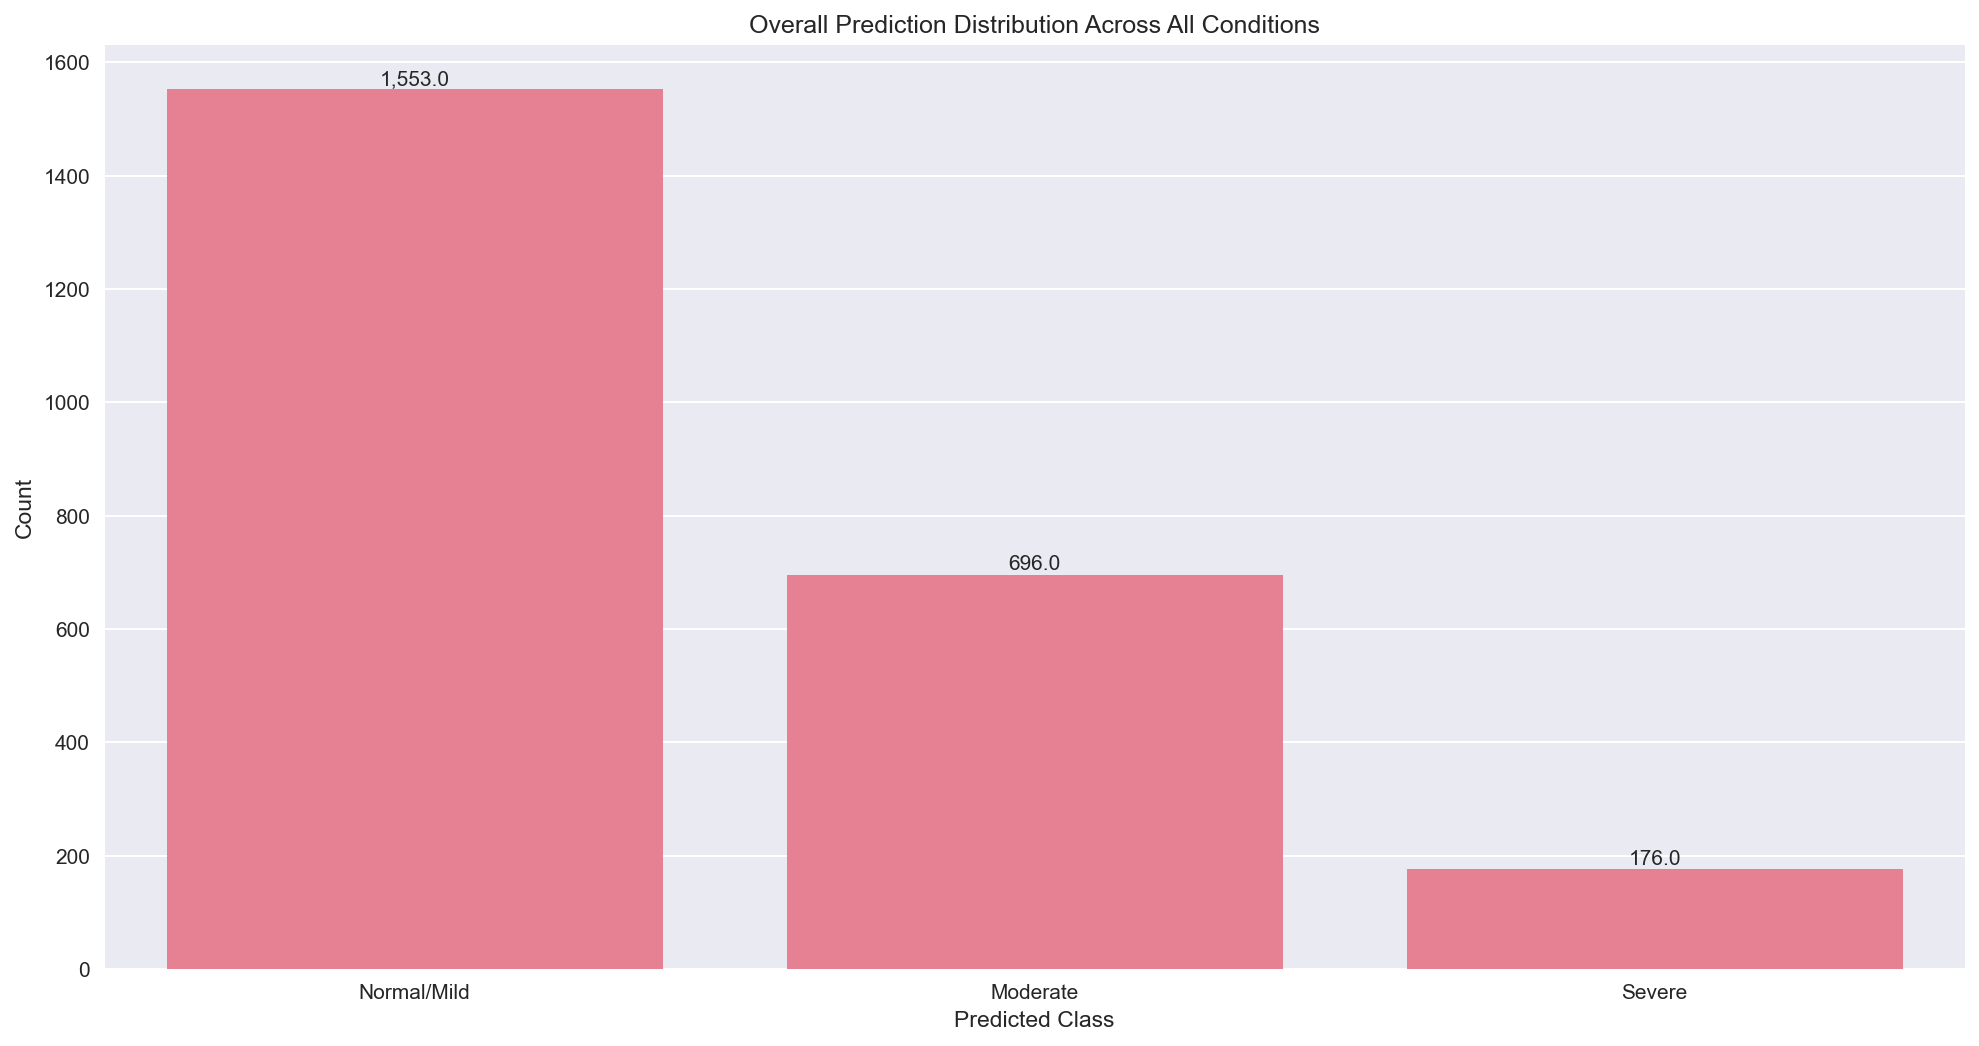

**Overall Prediction Distribution** | [Saved to D:\DATASET-LUMBAR\prediction_analysis\overall_pred_distribution.png]


🔵 2. Condition-wise Prediction Distributions...


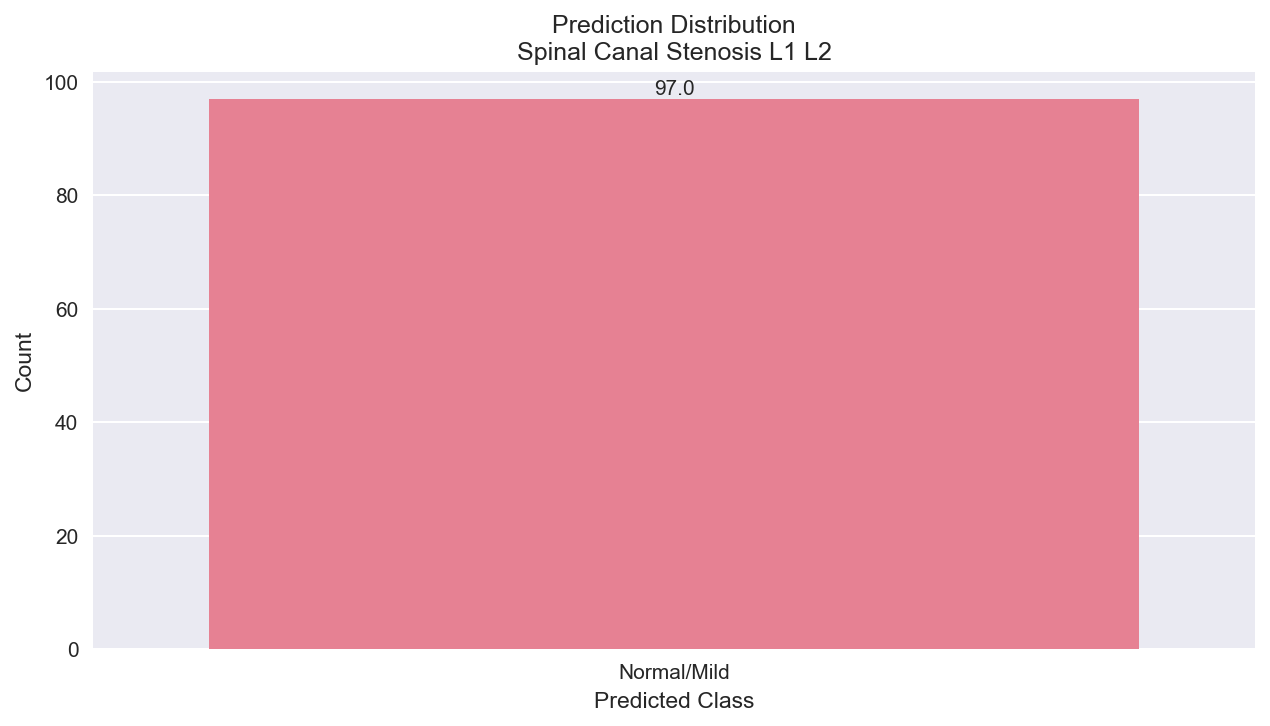

**spinal_canal_stenosis_l1_l2** | [Saved to D:\DATASET-LUMBAR\prediction_analysis\pred_dist_spinal_canal_stenosis_l1_l2.png]

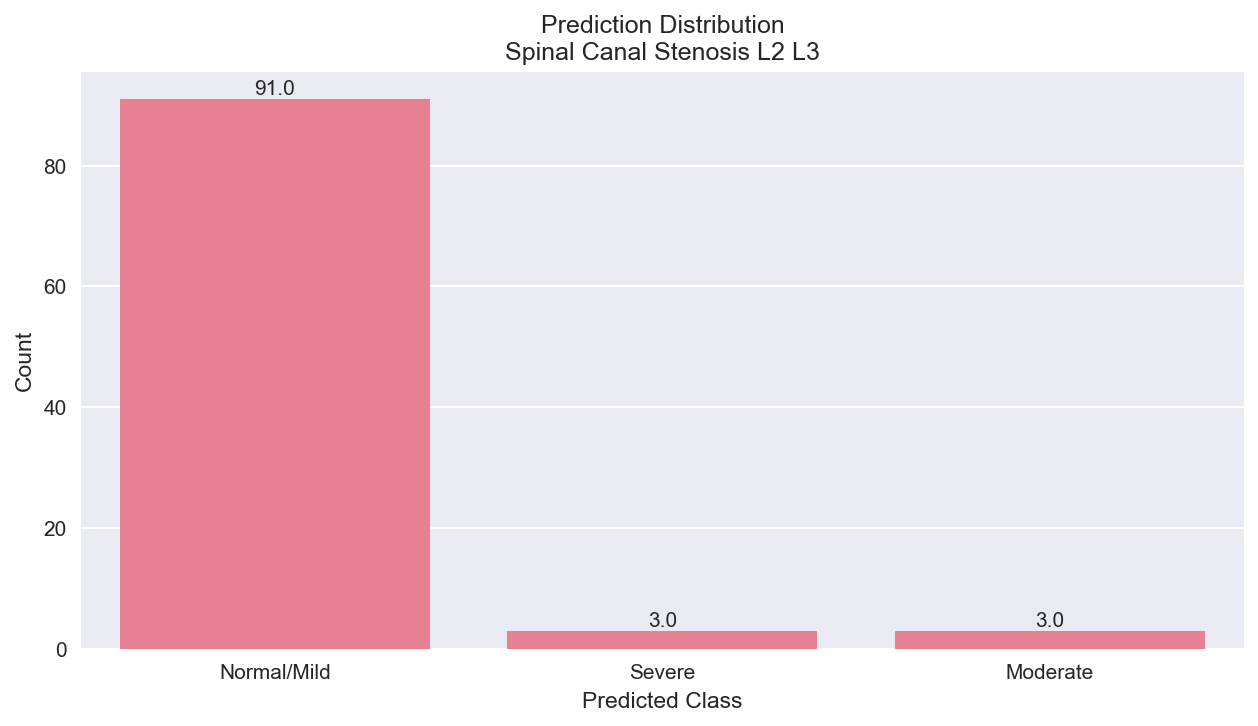

**spinal_canal_stenosis_l2_l3** | [Saved to D:\DATASET-LUMBAR\prediction_analysis\pred_dist_spinal_canal_stenosis_l2_l3.png]

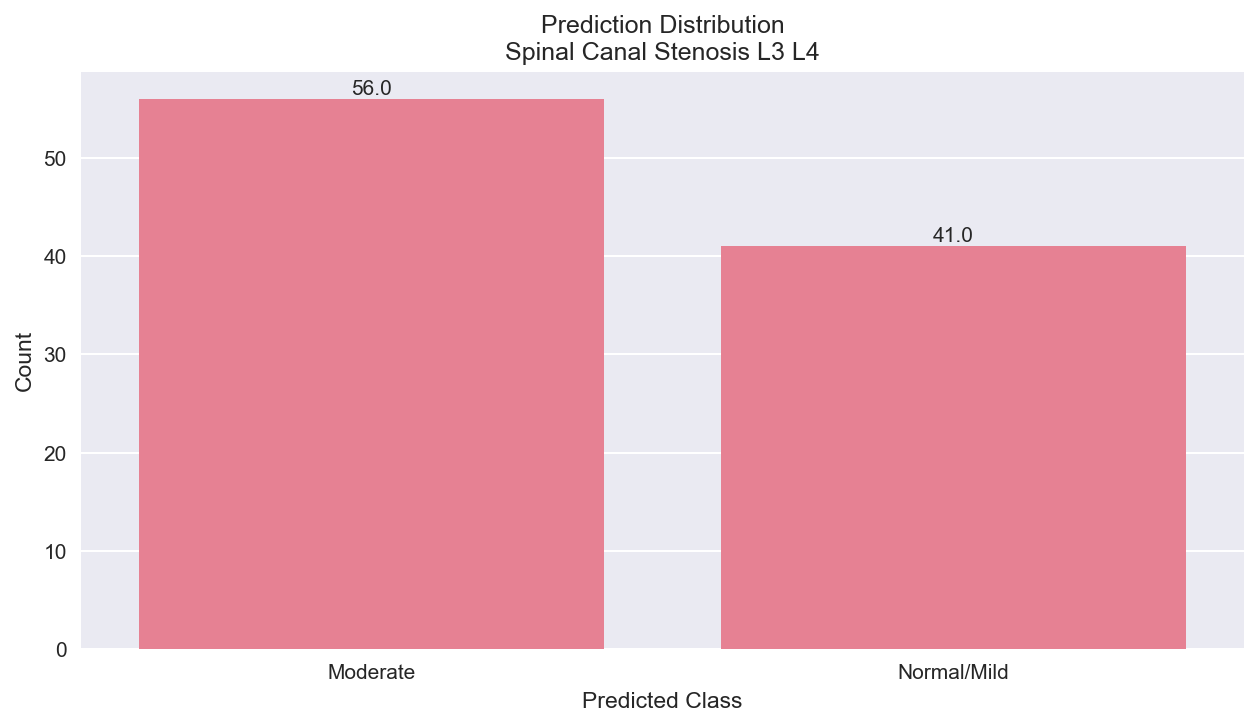

**spinal_canal_stenosis_l3_l4** | [Saved to D:\DATASET-LUMBAR\prediction_analysis\pred_dist_spinal_canal_stenosis_l3_l4.png]

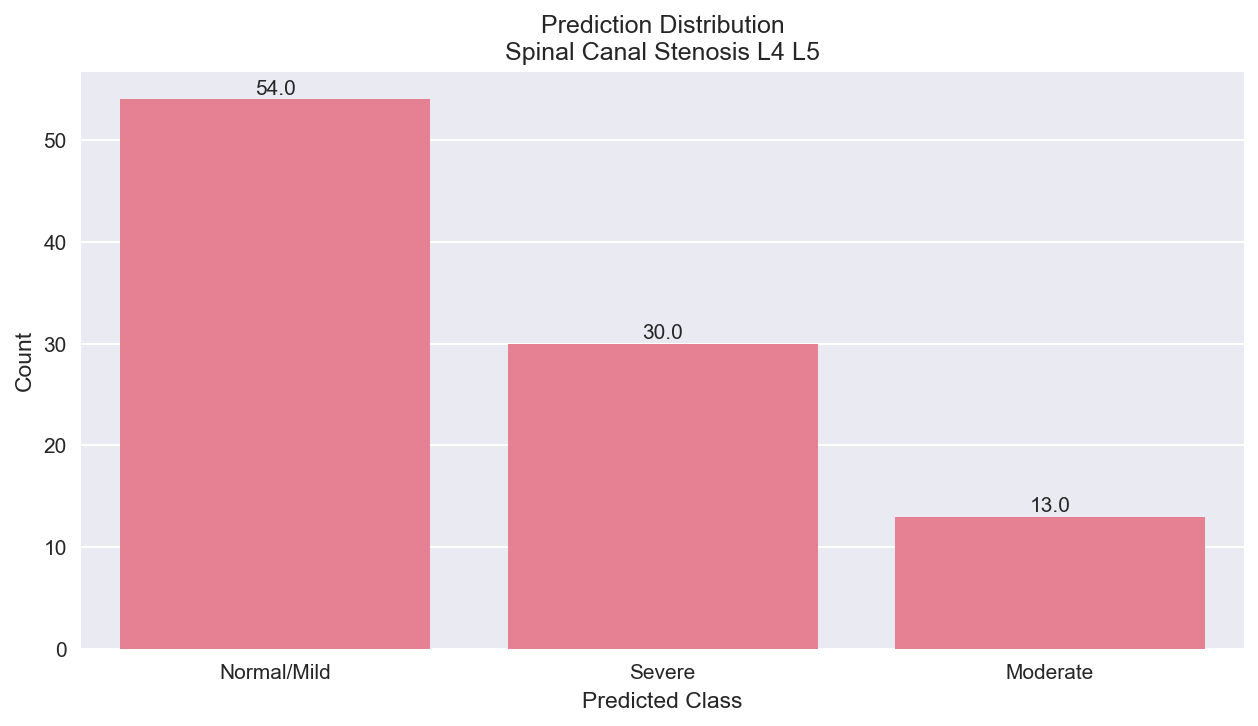

**spinal_canal_stenosis_l4_l5** | [Saved to D:\DATASET-LUMBAR\prediction_analysis\pred_dist_spinal_canal_stenosis_l4_l5.png]

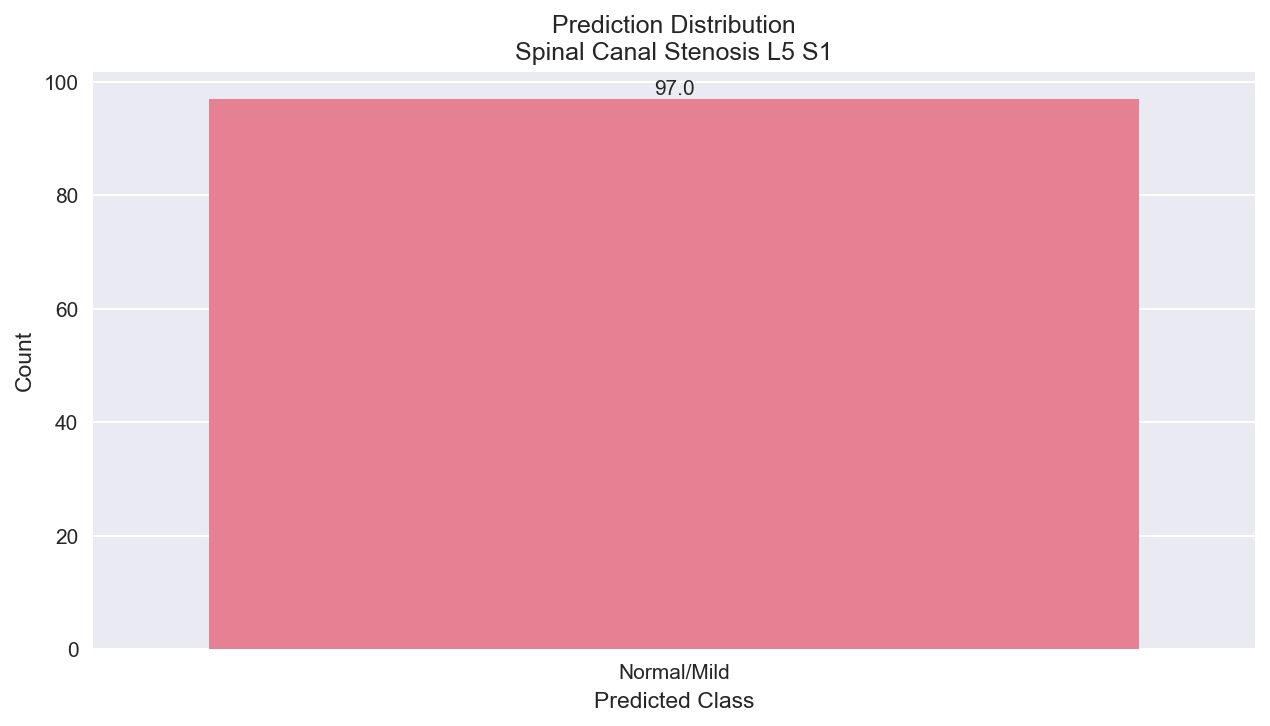

**spinal_canal_stenosis_l5_s1** | [Saved to D:\DATASET-LUMBAR\prediction_analysis\pred_dist_spinal_canal_stenosis_l5_s1.png]


🔵 3. Probability Distributions...


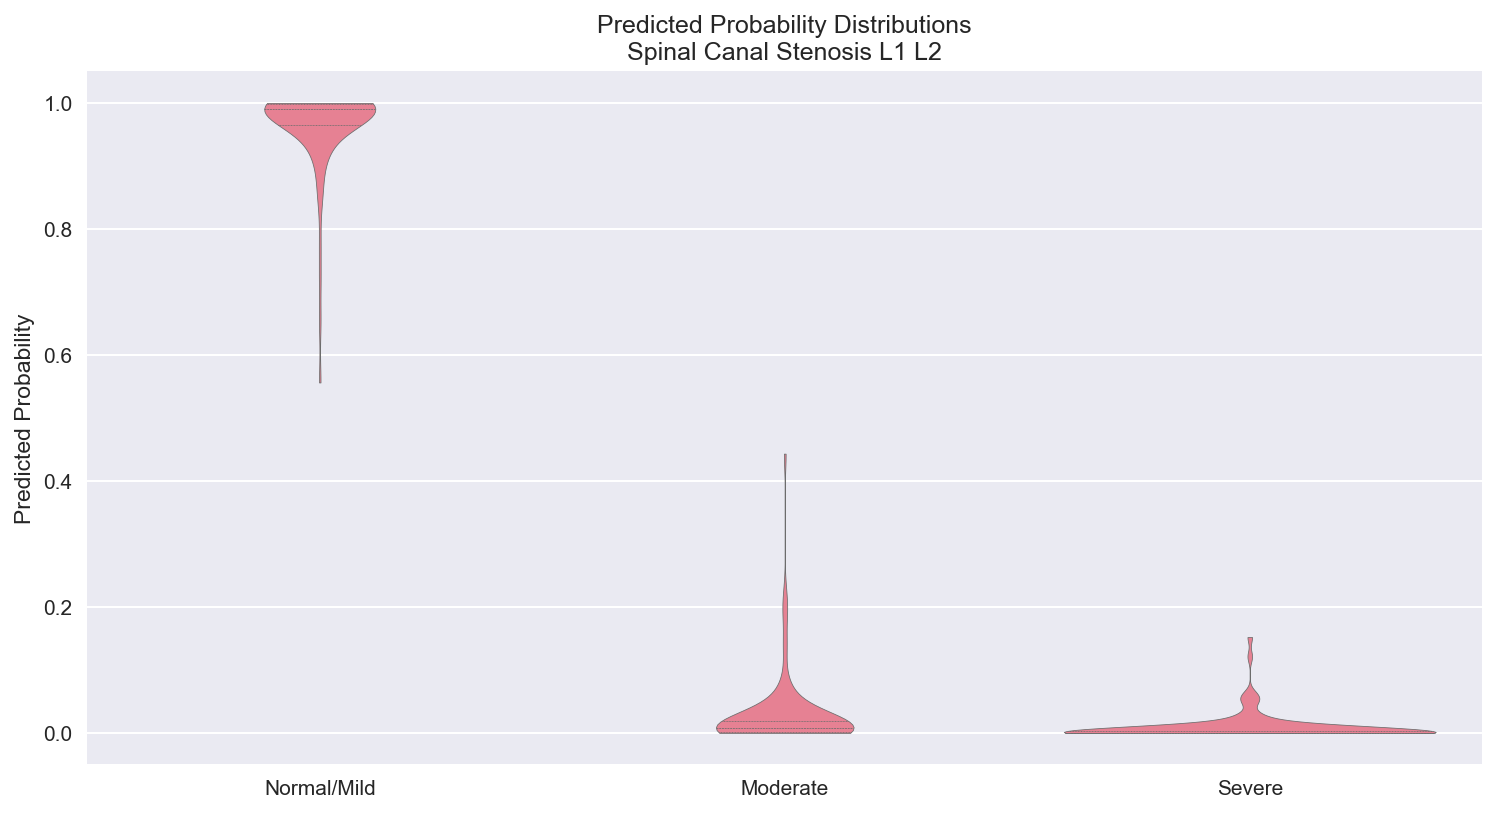

**spinal_canal_stenosis_l1_l2** | [Saved to D:\DATASET-LUMBAR\prediction_analysis\prob_dist_spinal_canal_stenosis_l1_l2.png]

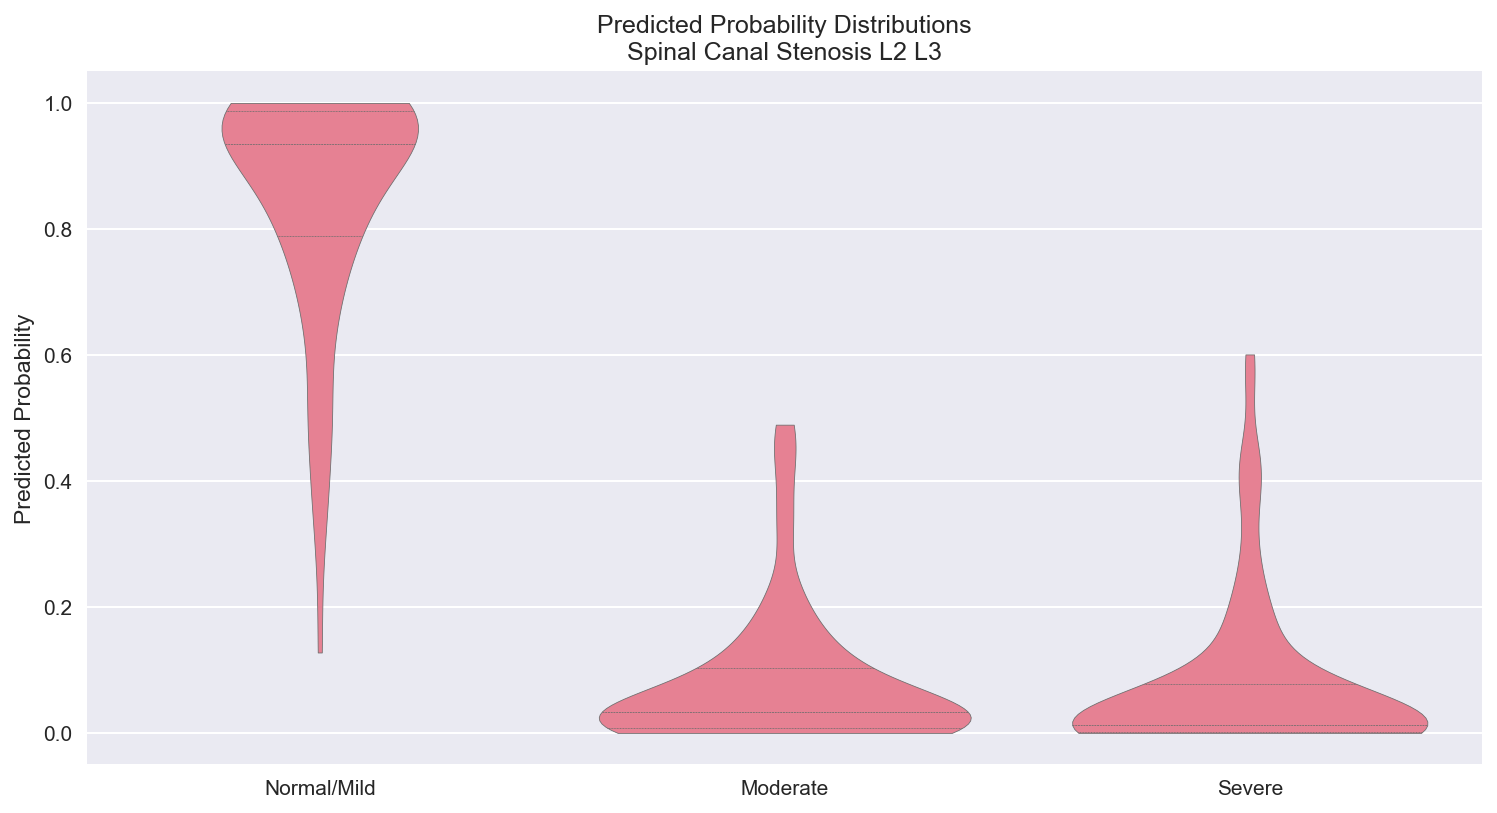

**spinal_canal_stenosis_l2_l3** | [Saved to D:\DATASET-LUMBAR\prediction_analysis\prob_dist_spinal_canal_stenosis_l2_l3.png]

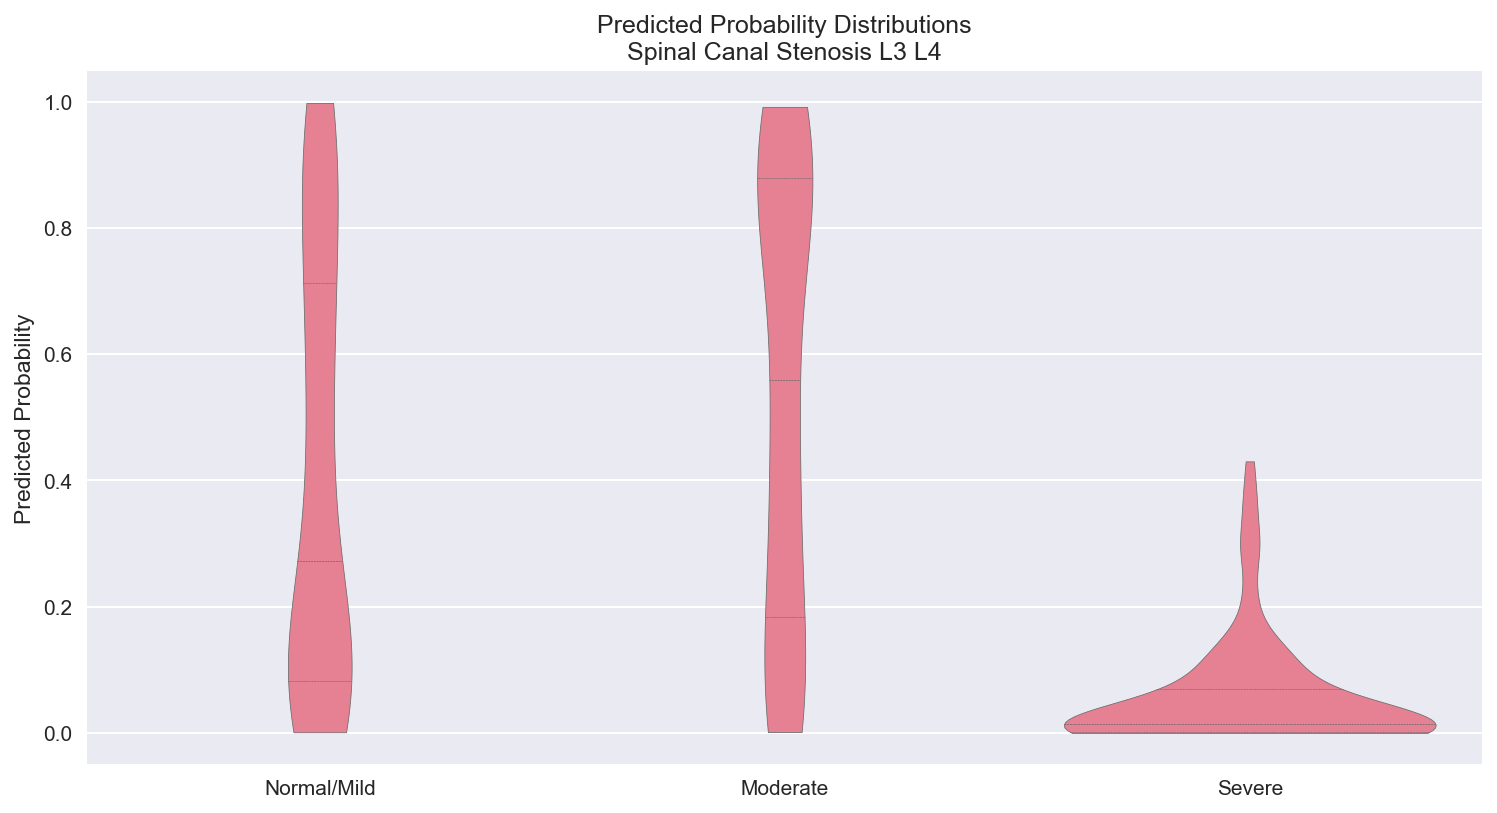

**spinal_canal_stenosis_l3_l4** | [Saved to D:\DATASET-LUMBAR\prediction_analysis\prob_dist_spinal_canal_stenosis_l3_l4.png]


🔵 4. Prediction Confidence Analysis...


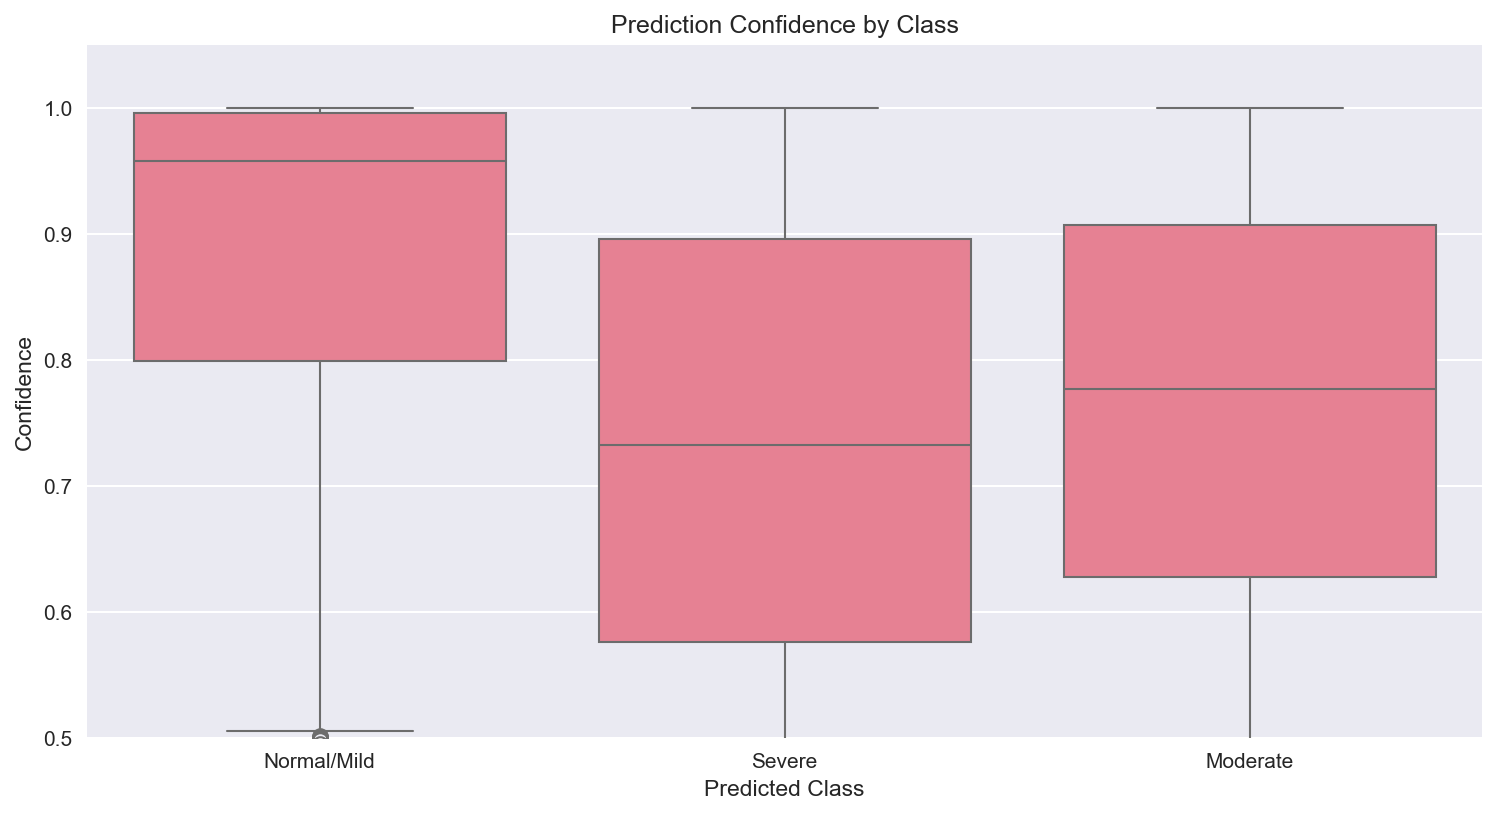

**Prediction Confidence** | [Saved to D:\DATASET-LUMBAR\prediction_analysis\prediction_confidence.png]

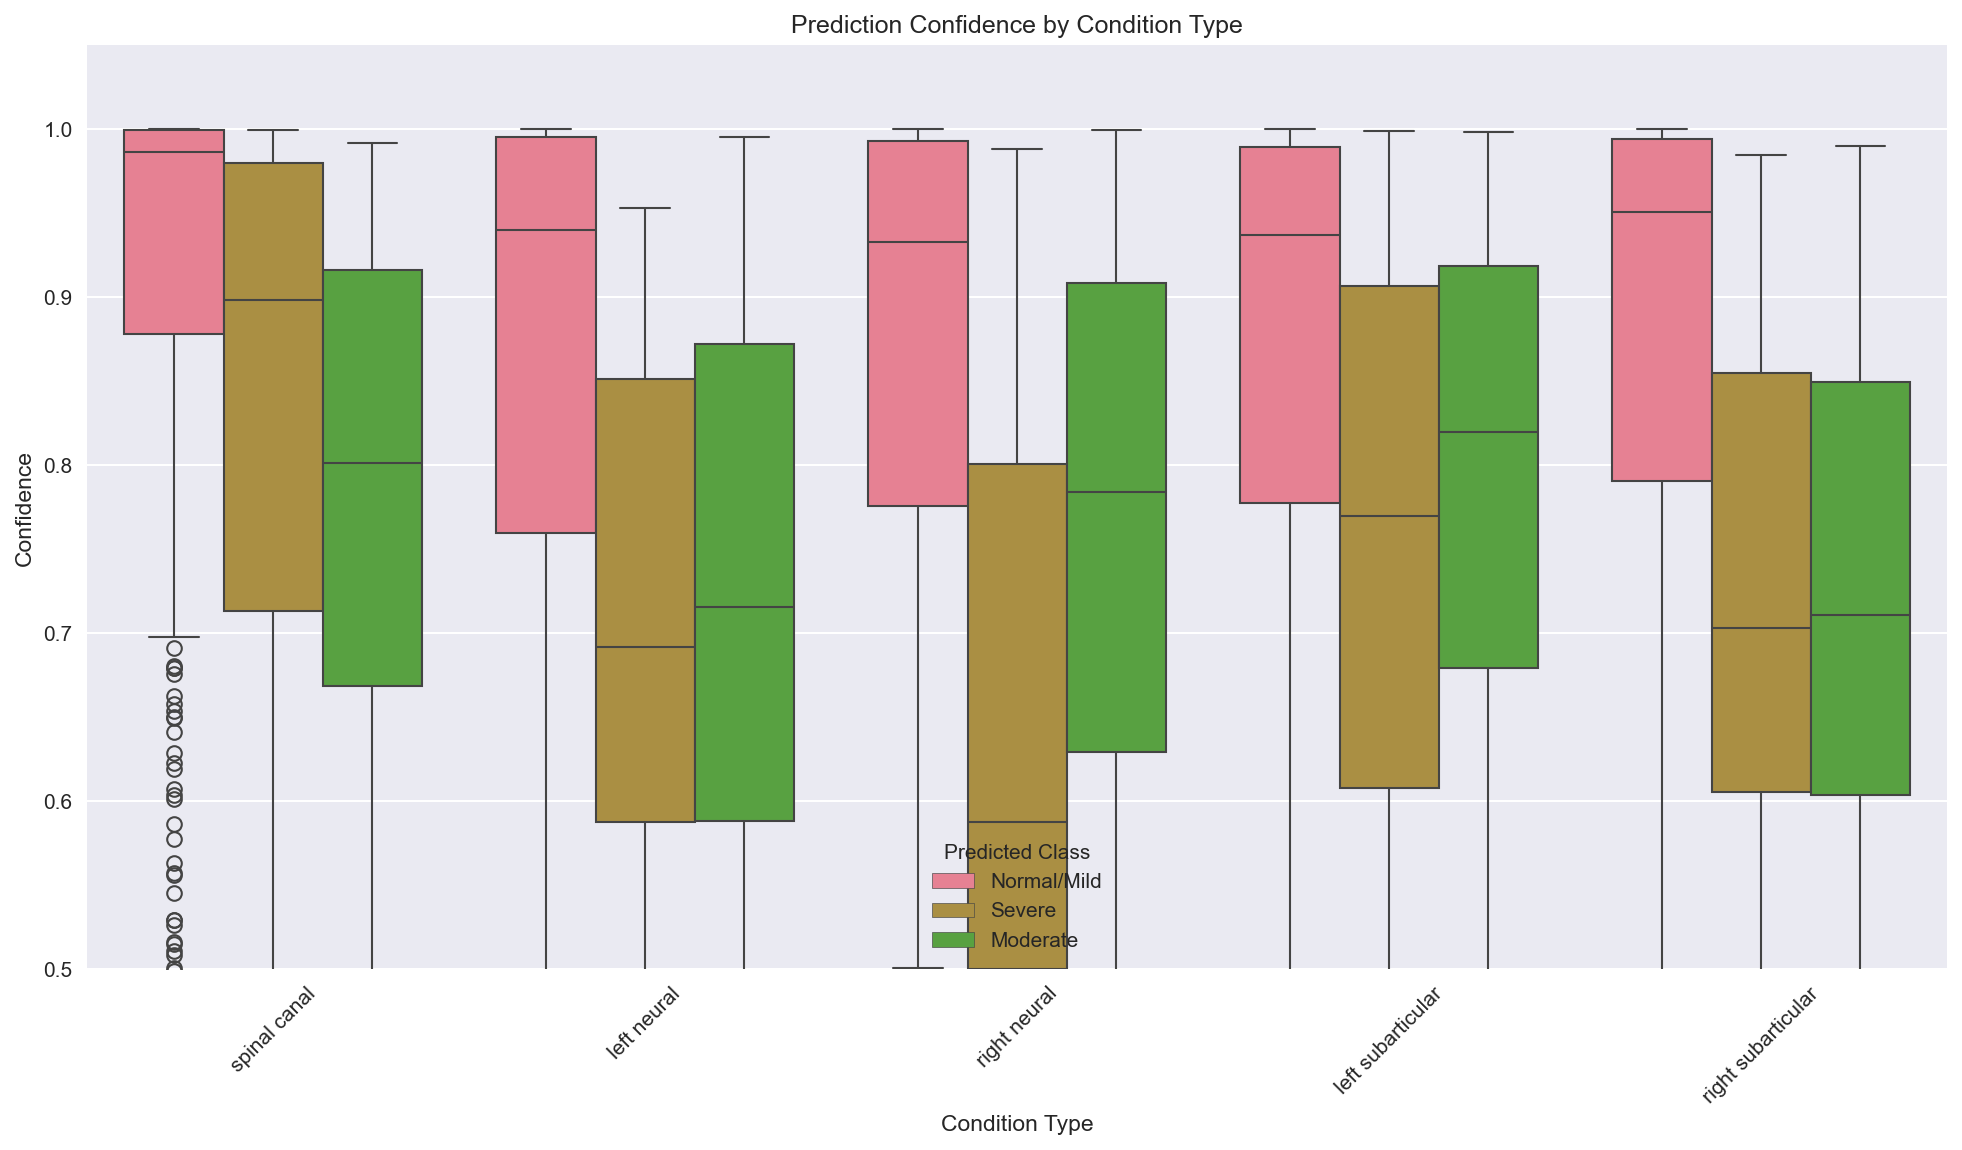

**Confidence by Condition Type** | [Saved to D:\DATASET-LUMBAR\prediction_analysis\confidence_by_condition_type.png]


🎉 All prediction analysis visualizations completed!


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display, Markdown

# =============================================
# 1. CONFIGURATION AND SETUP
# =============================================
# Set plotting style
plt.style.use('seaborn-v0_8') if 'seaborn-v0_8' in plt.style.available else plt.style.use('ggplot')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (10, 6)

# Base directory
BASE_PATH = r"D:\DATASET-LUMBAR"
PREDICTIONS_PATH = os.path.join(BASE_PATH, "test_predictions.csv")

# =============================================
# 2. DATA LOADING AND PREPARATION
# =============================================
try:
    pred_df = pd.read_csv(PREDICTIONS_PATH)
    print(f"✅ Loaded predictions data with {len(pred_df)} cases")
except Exception as e:
    raise FileNotFoundError(f"Could not load predictions CSV: {str(e)}")

# Define all 25 conditions
condition_types = ['spinal_canal_stenosis', 'left_neural_foraminal_narrowing', 
                  'right_neural_foraminal_narrowing', 'left_subarticular_stenosis',
                  'right_subarticular_stenosis']
levels = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']
condition_columns = [f"{cond}_{level}" for cond in condition_types for level in levels]

# Create output directories
os.makedirs(os.path.join(BASE_PATH, "prediction_analysis"), exist_ok=True)

# =============================================
# 3. PREDICTION ANALYSIS VISUALIZATIONS
# =============================================

# A. PREDICTION DISTRIBUTION ACROSS ALL CONDITIONS
print("\n🔵 1. Prediction Distribution Across All Conditions...")
plt.figure(figsize=(16, 8))

# Count predictions for each class across all conditions
all_preds = []
for cond in condition_columns:
    if f"pred_{cond}_label" in pred_df.columns:
        all_preds.extend(pred_df[f"pred_{cond}_label"].values)

if all_preds:
    pred_counts = pd.Series(all_preds).value_counts()
    ax = sns.barplot(x=pred_counts.index, y=pred_counts.values)
    
    # Add counts on top of bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():,}", 
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    
    plt.title('Overall Prediction Distribution Across All Conditions')
    plt.xlabel('Predicted Class')
    plt.ylabel('Count')
    
    save_path = os.path.join(BASE_PATH, "prediction_analysis", "overall_pred_distribution.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    display(Markdown(f"**Overall Prediction Distribution** | [Saved to {save_path}]"))
else:
    print("⚠️ No prediction label columns found")

# B. CONDITION-WISE PREDICTION DISTRIBUTIONS
print("\n🔵 2. Condition-wise Prediction Distributions...")
for condition in condition_columns[:5]:  # Show first 5 for demo
    if f"pred_{condition}_label" in pred_df.columns:
        plt.figure(figsize=(10,5))
        
        # Get prediction counts
        pred_counts = pred_df[f"pred_{condition}_label"].value_counts()
        
        # Create plot
        ax = sns.barplot(x=pred_counts.index, y=pred_counts.values)
        plt.title(f'Prediction Distribution\n{condition.replace("_", " ").title()}')
        plt.xlabel('Predicted Class')
        plt.ylabel('Count')
        
        # Add counts on bars
        for p in ax.patches:
            ax.annotate(f"{p.get_height()}", 
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 5), textcoords='offset points')
        
        save_path = os.path.join(BASE_PATH, "prediction_analysis", f"pred_dist_{condition}.png")
        plt.savefig(save_path, bbox_inches='tight')
        plt.show()
        display(Markdown(f"**{condition}** | [Saved to {save_path}]"))
        plt.close()

# C. PROBABILITY DISTRIBUTION VIOLIN PLOTS
print("\n🔵 3. Probability Distributions...")
for condition in condition_columns[:3]:  # Show first 3 for demo
    try:
        plt.figure(figsize=(12,6))
        
        # Melt probability columns
        prob_cols = [f"prob_{condition}_Normal/Mild", 
                    f"prob_{condition}_Moderate", 
                    f"prob_{condition}_Severe"]
        
        prob_df = pred_df[prob_cols].melt(var_name='Class', value_name='Probability')
        prob_df['Class'] = prob_df['Class'].str.replace(f"prob_{condition}_", "")
        
        # Create violin plot
        sns.violinplot(data=prob_df, x='Class', y='Probability', cut=0, inner='quartile')
        plt.title(f'Predicted Probability Distributions\n{condition.replace("_", " ").title()}')
        plt.xlabel('')
        plt.ylabel('Predicted Probability')
        
        save_path = os.path.join(BASE_PATH, "prediction_analysis", f"prob_dist_{condition}.png")
        plt.savefig(save_path, bbox_inches='tight')
        plt.show()
        display(Markdown(f"**{condition}** | [Saved to {save_path}]"))
        plt.close()
    except Exception as e:
        print(f"⚠️ Could not generate for {condition}: {str(e)}")

# D. PREDICTION CONFIDENCE ANALYSIS
print("\n🔵 4. Prediction Confidence Analysis...")
confidence_data = []
for condition in condition_columns:
    if f"pred_{condition}_label" in pred_df.columns and f"prob_{condition}_Normal/Mild" in pred_df.columns:
        for _, row in pred_df.iterrows():
            pred_class = row[f"pred_{condition}_label"]
            confidence = row[f"prob_{condition}_{pred_class}"]
            confidence_data.append({
                'Condition': condition,
                'Predicted Class': pred_class,
                'Confidence': confidence
            })

if confidence_data:
    conf_df = pd.DataFrame(confidence_data)
    
    # Plot confidence by class
    plt.figure(figsize=(12,6))
    sns.boxplot(data=conf_df, x='Predicted Class', y='Confidence')
    plt.title('Prediction Confidence by Class')
    plt.ylim(0.5, 1.05)
    
    save_path = os.path.join(BASE_PATH, "prediction_analysis", "prediction_confidence.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    display(Markdown(f"**Prediction Confidence** | [Saved to {save_path}]"))
    plt.close()

    # Plot confidence by condition type
    plt.figure(figsize=(16,8))
    conf_df['Condition Type'] = conf_df['Condition'].str.split('_').str[0:2].str.join(' ')
    sns.boxplot(data=conf_df, x='Condition Type', y='Confidence', hue='Predicted Class')
    plt.title('Prediction Confidence by Condition Type')
    plt.xticks(rotation=45)
    plt.ylim(0.5, 1.05)
    
    save_path = os.path.join(BASE_PATH, "prediction_analysis", "confidence_by_condition_type.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    display(Markdown(f"**Confidence by Condition Type** | [Saved to {save_path}]"))
    plt.close()
else:
    print("⚠️ Could not calculate prediction confidence")

print("\n🎉 All prediction analysis visualizations completed!")